In [1]:
#importing the libraries

#Data Processing Libraries
import numpy as np
import pandas as pd

#Data Vizualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Library
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer # Imputer Class to replace missing values
from sklearn.metrics import confusion_matrix # Library for model evaluation
from sklearn.metrics import accuracy_score # Library for model evaluation
from sklearn.model_selection import train_test_split # Library to split datset into test and train

from sklearn.linear_model  import LogisticRegression # Logistic Regression Classifier
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier
from sklearn.ensemble  import RandomForestClassifier # Random Forest Classifier
from sklearn.neighbors import KNeighborsClassifier # K Nearest neighbors Classifier
from sklearn.naive_bayes import GaussianNB #Naive Bayes Classifier
from sklearn.svm import SVC #Support vector Machine Classifier
from sklearn.ensemble import AdaBoostClassifier # Ada Boost Classifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

### Load dataset

In [2]:
df = pd.read_csv('telco.csv')
df.describe()
#df[df['TotalCharges'] == ' '].index

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


### Exporatory Data Analysis (EDA)

<Axes: xlabel='Churn', ylabel='count'>

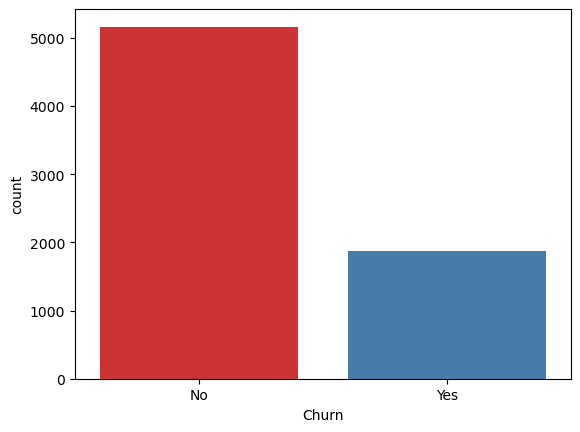

In [3]:
fig, ax = plt.subplots()
sns.countplot(x=df['Churn'], hue=df['Churn'], palette = 'Set1')

<Axes: xlabel='tenure', ylabel='Count'>

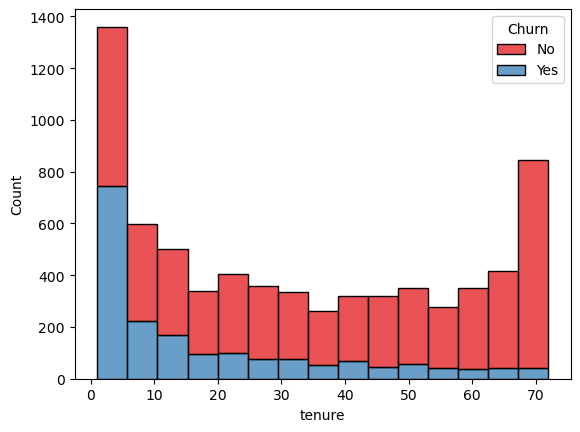

In [4]:
fig, ax = plt.subplots()
sns.histplot(df, x='tenure', hue='Churn', multiple='stack', palette = 'Set1')

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

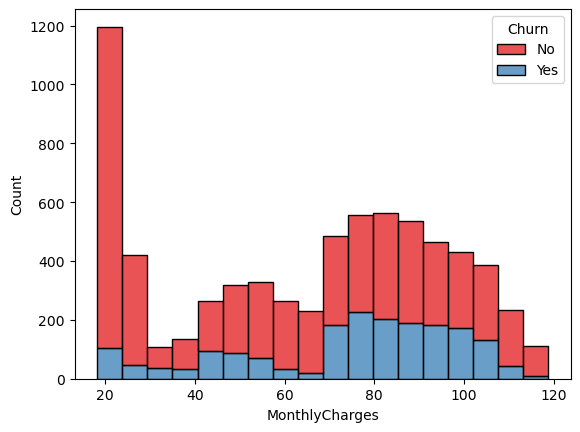

In [5]:
fig, ax = plt.subplots()
sns.histplot(df, x='MonthlyCharges', hue='Churn', multiple='stack', palette = 'Set1')

<Axes: xlabel='TotalCharges', ylabel='Count'>

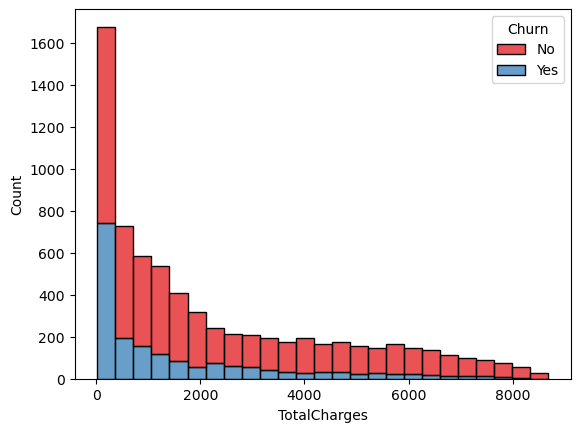

In [6]:
fig, ax = plt.subplots()
sns.histplot(df, x='TotalCharges', hue='Churn', multiple='stack', palette = 'Set1')

<Axes: xlabel='PaymentMethod', ylabel='Count'>

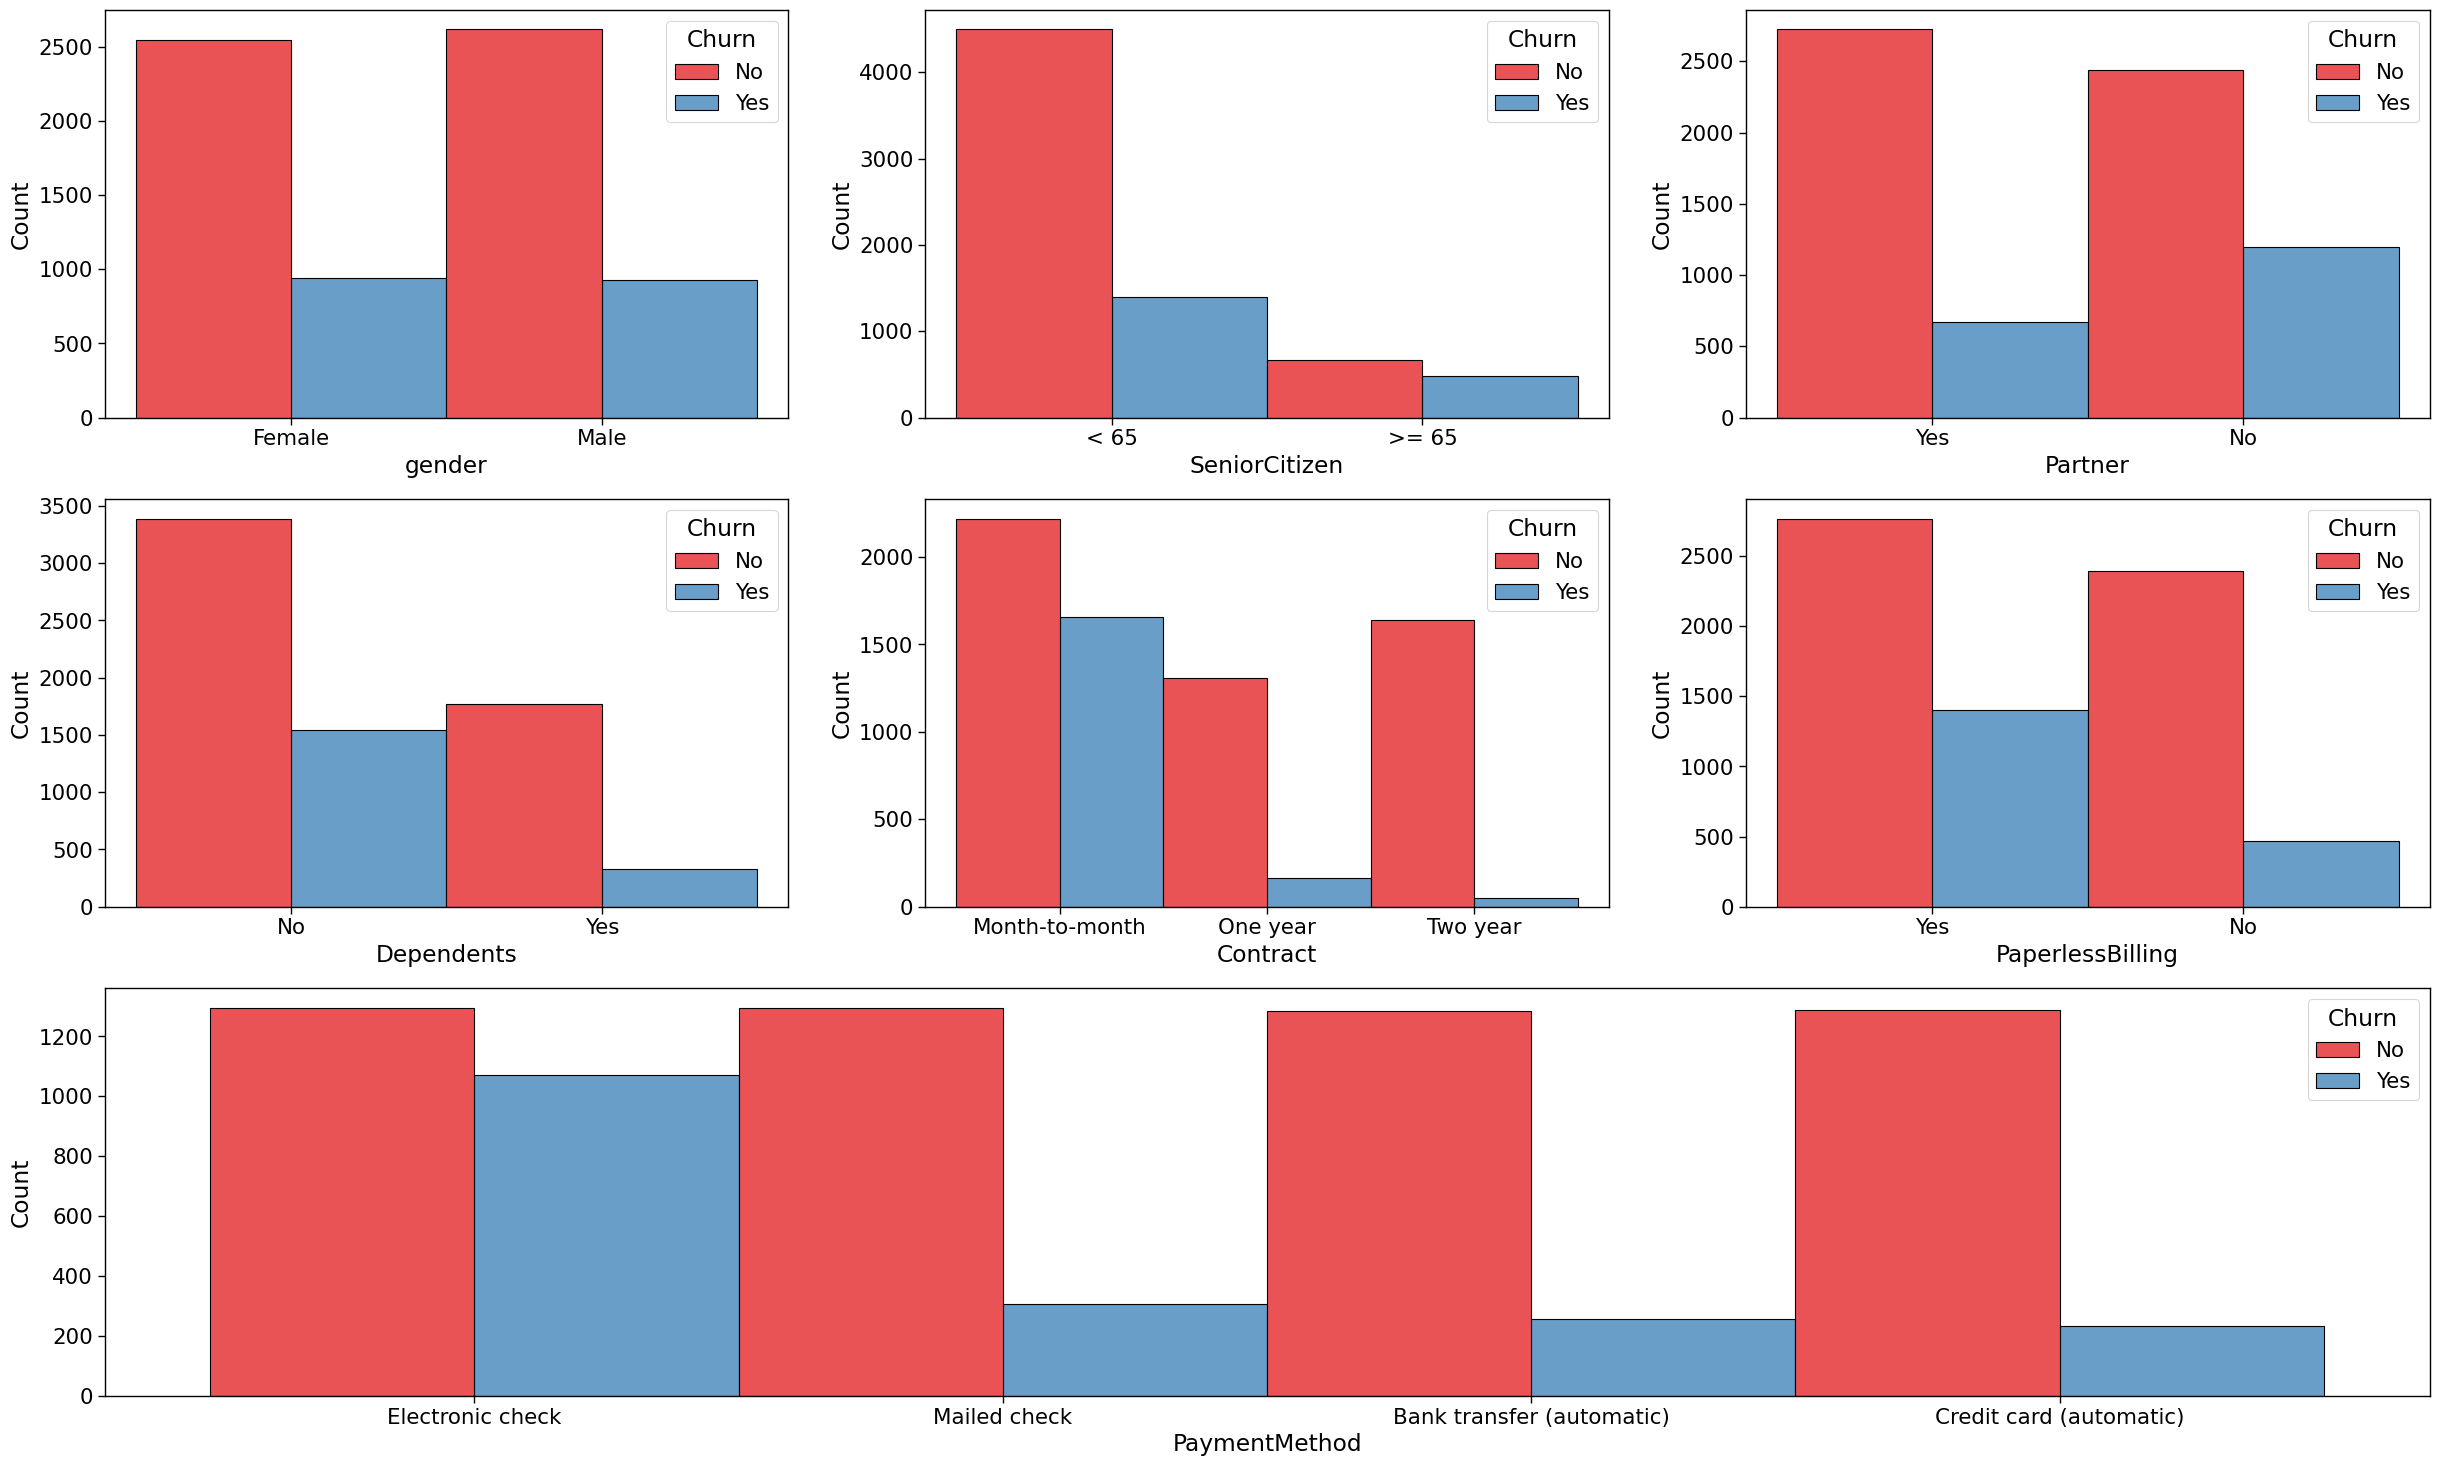

In [7]:
df['SeniorCitizen'] = df['SeniorCitizen'].replace({0: '< 65', 1:">= 65"})
sns.set_context('paper', font_scale=1.75)
plt.figure(1,figsize=(30,18))
plt.subplot(331)
sns.histplot(df, x='gender', hue='Churn', multiple='dodge', palette = 'Set1')
plt.subplot(332)
sns.histplot(df, x='SeniorCitizen', hue='Churn', multiple='dodge', palette = 'Set1')
plt.subplot(333)
sns.histplot(df, x='Partner', hue='Churn', multiple='dodge', palette = 'Set1')
plt.subplot(334)
sns.histplot(df, x='Dependents', hue='Churn', multiple='dodge', palette = 'Set1')
plt.subplot(335)
sns.histplot(df, x='Contract', hue='Churn', multiple='dodge', palette = 'Set1')
plt.subplot(336)
sns.histplot(df, x='PaperlessBilling', hue='Churn', multiple='dodge', palette = 'Set1')
plt.subplot(313)
#plt.xticks(rotation=45)
sns.histplot(df, x='PaymentMethod', hue='Churn', multiple='dodge', palette = 'Set1')

In [8]:
# Convert all yes and no to 0's & 1's so our classifier can use this data.
df['SeniorCitizen'] = df['SeniorCitizen'].replace({'< 65': '0', ">= 65": '1'})
# convert column "SeniorCitizen" to int
df = df.astype({"SeniorCitizen": int})
columns_to_convert = ['Partner', 
                      'Dependents', 
                      'PhoneService', 
                      'OnlineSecurity',
                      'DeviceProtection',
                      'TechSupport',
                      'StreamingTV',
                      'StreamingMovies',
                      'PaperlessBilling', 
                      'Churn']

for item in columns_to_convert:
    df[item] = df[item].replace(to_replace='Yes', value='1')
    df[item] = df[item].replace(to_replace='No',  value='0')
    df[item] = df[item].replace(to_replace='No internet service',  value='0')
    df = df.astype({item: int})

#### Feature Selection: Correlation matrix

<Axes: >

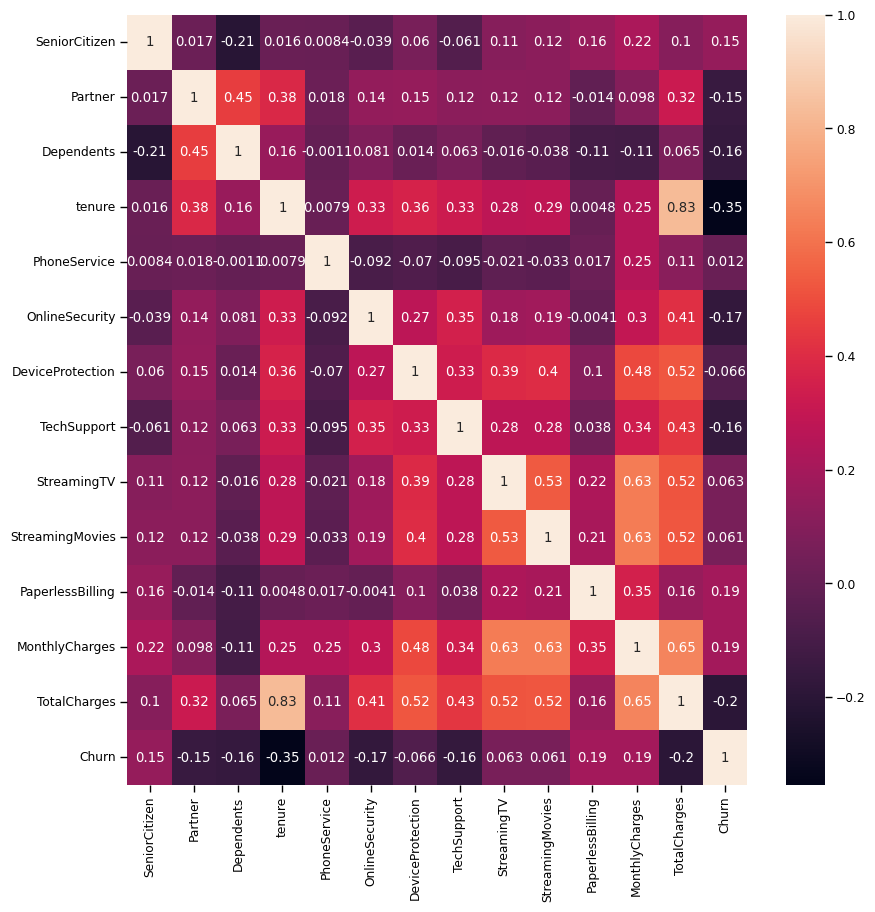

In [9]:
sns.set_context('paper', font_scale=1)
# compute the pair wise correlation for all columns  
correlation_matrix = df.corr(numeric_only=True)
# use the heatmap function from seaborn to plot the correlation matrix
# Manipulate figsize in inches for 
fig, ax = plt.subplots(figsize=(10,10))
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

#### Split dataset

In [10]:
# remove customerID and TotalCharges
try:
    del df['customerID'] # not needed in analysis (it will lead to feature explosion in one hot encoding)
    del df['TotalCharges'] # highly correlated with tenure and MonthlyCharges
except:
    print("already removed customerID and TotalCharges")

# Split features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

In [11]:
# Split the data into training and test sets before scaling, encoding to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Encode categorical data

In [12]:
from category_encoders import OrdinalEncoder, OneHotEncoder

# Identify numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns
#print(cat_features)
      
# Use one-hot encoding to convert categorical data to binary (0 or 1)
# Apply ordinal encoding on categorical features
onehot_encoder = OneHotEncoder(return_df=True,
                                 handle_unknown='value',   # Handle unknown categories in the test set (at transform time) --> Encode a new value as 0 in every dummy column
                                )
new_cols_train = onehot_encoder.fit_transform(X_train[cat_features])
# Concatenate the original DataFrame with the encoded DataFrame
X_train = pd.concat([X_train, new_cols_train], axis=1)
# Drop the original categorical column if you no longer need it
X_train = X_train.drop(columns=cat_features)

new_cols_test = onehot_encoder.transform(X_test[cat_features])
X_test = pd.concat([X_test, new_cols_test], axis=1)
X_test = X_test.drop(columns=cat_features)

X_train.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,...,OnlineBackup_1,OnlineBackup_2,OnlineBackup_3,Contract_1,Contract_2,Contract_3,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4
6021,0,0,0,43,0,0,1,0,1,1,...,1,0,0,1,0,0,1,0,0,0
3404,0,0,0,3,1,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
5474,0,1,0,55,1,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
5515,0,1,1,45,1,1,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0
6328,0,1,1,55,1,1,0,0,1,1,...,1,0,0,0,0,1,0,0,0,1


#### Feature Selection: Forward Selection

best combination (ACC: 0.803): (0, 3, 4, 5, 9, 10, 12, 13, 14, 15, 16, 18, 23, 27, 28)



(<Figure size 1000x1000 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

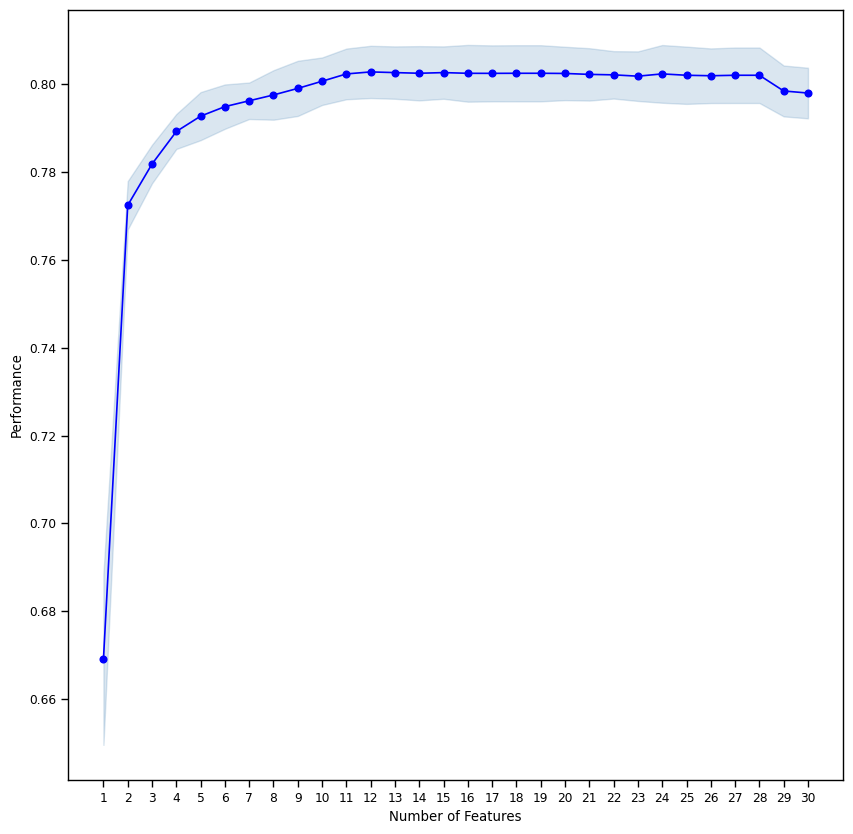

In [13]:
from sklearn.linear_model  import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

log = LogisticRegression(max_iter=1000)

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
f1_weighted = make_scorer(f1_score, average='weighted')

sfs_range = SFS(estimator=log, 
           k_features=(15, 30),
           forward=True, 
           floating=False, 
           scoring=f1_weighted,
           cv=5)

sfs_range = sfs_range.fit(X_train, y_train)

print('best combination (ACC: %.3f): %s\n' % (sfs_range.k_score_, sfs_range.k_feature_idx_))
# print('all subsets:\n', sfs_range.subsets_)
plt.rcParams["figure.figsize"] = (10,10)
plot_sfs(sfs_range.get_metric_dict(), kind='std_err')

In [14]:
# keep 15 most important features that maximize the accuracy
# Generate the new subsets based on the selected features
X_train = sfs_range.transform(X_train)
X_test = sfs_range.transform(X_test)

### Classification

#### We will run all classifiers to have an initial feeling of the performance

##### Defining function for Confusion Matrix , Precision, Recall and F1 Score

In [15]:
#Creating function for Confusion Matrix , Precsion, Recall and F1 Score
def plot_confusion_matrix(classifier, y_test, y_pred_test):
    cm = confusion_matrix(y_test, y_pred_test)
    
    print("\n",classifier,"\n")
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Churn-No','Churn-Yes']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    #F1 = 2*recall*precision/(recall+precision)
    F1 = f1_score(y_test, y_pred_test, average='weighted')

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))
    return;

##### Defining function for Precision Recall Curve

In [16]:
from sklearn.metrics import average_precision_score, precision_recall_curve
def plot_prec_rec_curve(classifier, y_test, y_pred_score):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_score)
    average_precision = average_precision_score(y_test, y_pred_score)

    print('Average precision-recall score: {0:0.3f}'.format(
          average_precision))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

#### Master Classification Engine


 LogisticRegression 



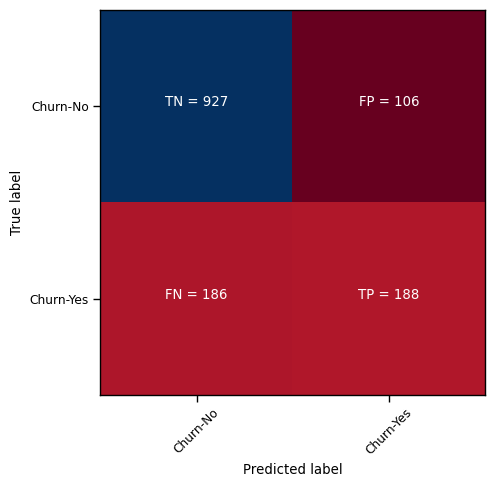

Recall=0.503 
Precision=0.639
F1=0.784
Average precision-recall score: 0.622


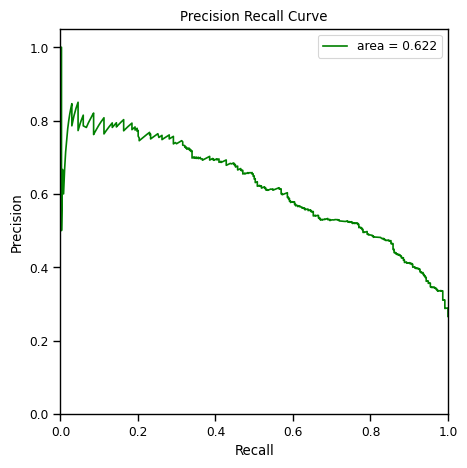


 KNeighborsClassifier 



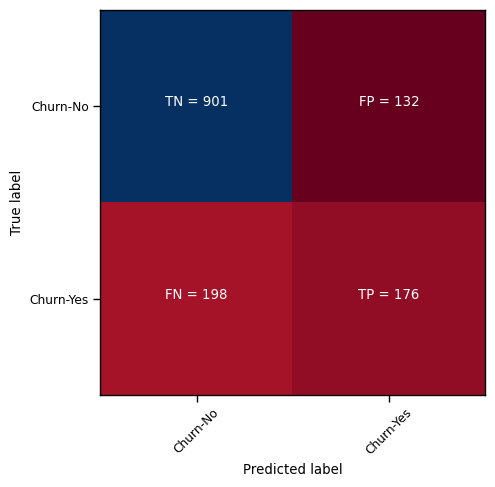

Recall=0.471 
Precision=0.571
F1=0.758
Average precision-recall score: 0.519


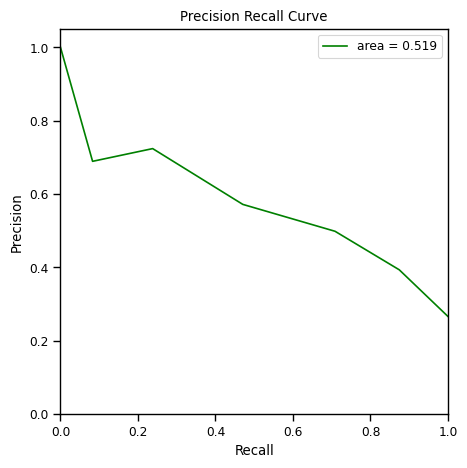


 GaussianNB 



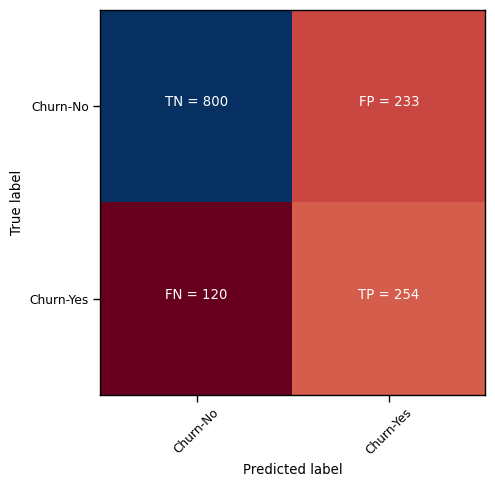

Recall=0.679 
Precision=0.522
F1=0.758
Average precision-recall score: 0.566


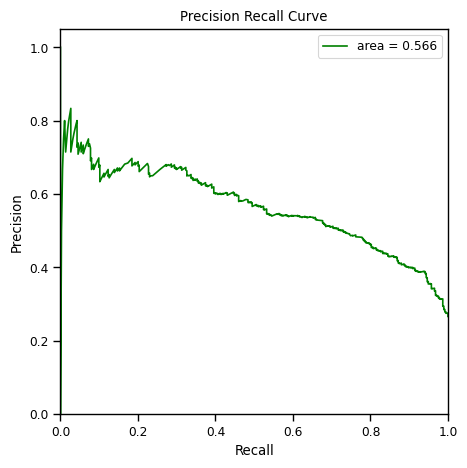


 SVC 



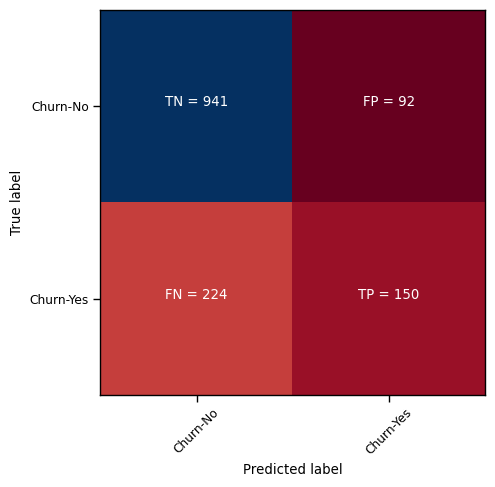

Recall=0.401 
Precision=0.620
F1=0.758
Average precision-recall score: 0.615


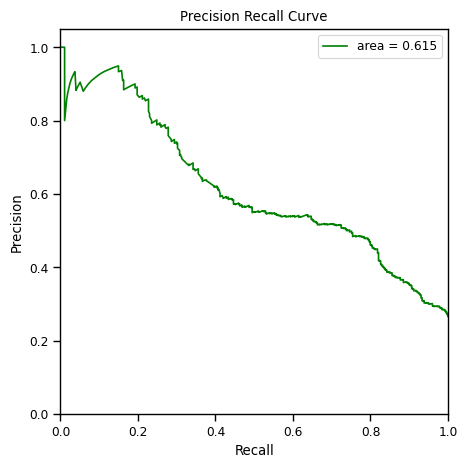


 DecisionTreeClassifier 



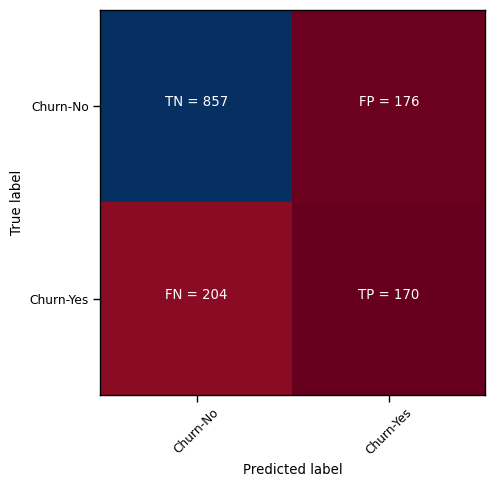

Recall=0.455 
Precision=0.491
F1=0.726
Average precision-recall score: 0.371


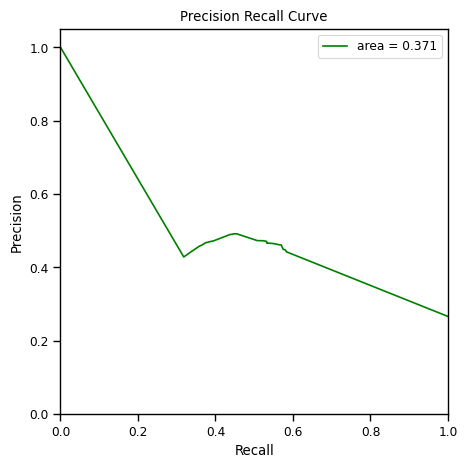


 RandomForestClassifier 



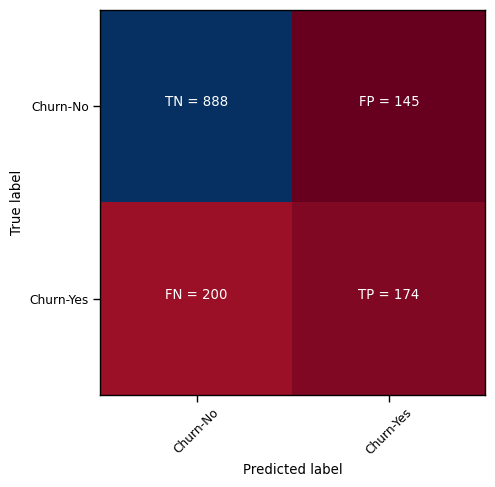

Recall=0.465 
Precision=0.545
F1=0.748
Average precision-recall score: 0.541


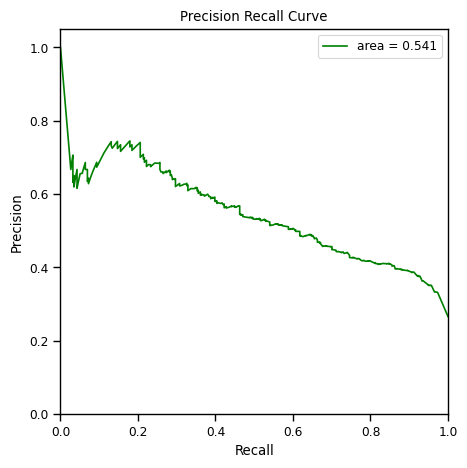


 SGDClassifier 



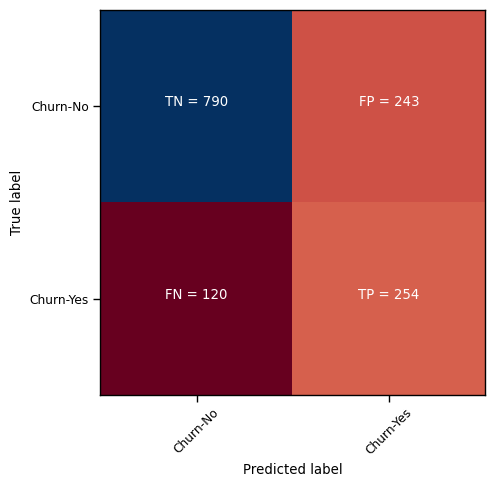

Recall=0.679 
Precision=0.511
F1=0.752
Average precision-recall score: 0.541


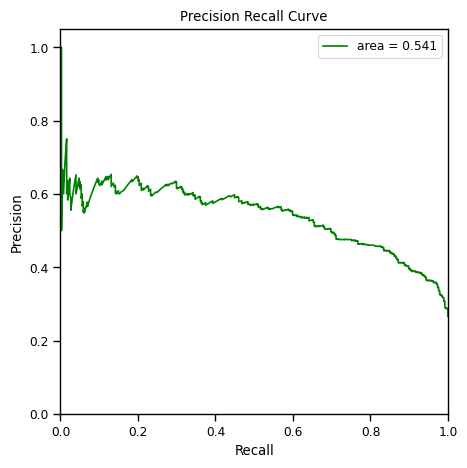


 AdaBoostClassifier 



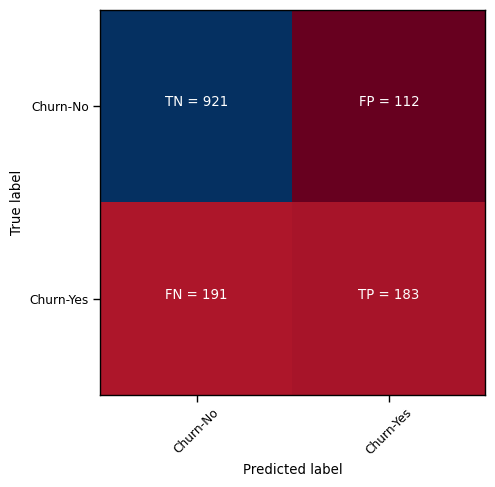

Recall=0.489 
Precision=0.620
F1=0.776
Average precision-recall score: 0.637


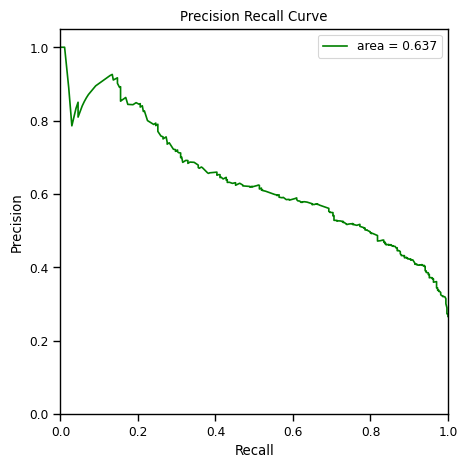

In [17]:
plt.rcParams["figure.figsize"] = (5,5)

# Making a list of all classifiers
classifier_model = [
    LogisticRegression(max_iter=1000), 
    KNeighborsClassifier(), 
    GaussianNB(), 
    SVC(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    SGDClassifier(), 
    AdaBoostClassifier(algorithm='SAMME')
]

# Creating empty list to store the performance details
classifier_model_list= []
classifier_accuracy_test = []
classifier_accuracy_train = []
f1score = []
precisionscore = []
recallscore = []
avg_pre_rec_score = []
cv_score = []

for classifier_list in classifier_model:
    classifier = classifier_list
 
    # Fitting the training set into classification model
    classifier.fit(X_train,y_train)
    
    # Predicting the output on test dataset
    y_pred_test = classifier.predict(X_test)    
    score_test = accuracy_score(y_test, y_pred_test)
    
    # Predicting the output on training datset
    y_pred_train = classifier.predict(X_train) 
    score_train = accuracy_score(y_train, y_pred_train)
    
    # Cross Validation Score on training test
    scores = cross_val_score(classifier, X_train,y_train, cv=10)
    cv_score.append(scores.mean())
    
    #Keeping the model and accuracy score into a list
    classifier_model_list.append(classifier_list.__class__.__name__)
    classifier_accuracy_test.append(round(score_test,4))
    classifier_accuracy_train.append(round(score_train,4))
    
    #Precision, Recall and F1 score
    f1score.append(f1_score(y_test, y_pred_test, average='weighted'))
    precisionscore.append(precision_score(y_test, y_pred_test))
    recallscore.append(recall_score(y_test, y_pred_test))
    
    #Calculating Average Precision Recall Score
    try:
        y_pred_score = classifier.decision_function(X_test)
    except:
        y_pred_score = classifier.predict_proba(X_test)[:,1]
    
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, y_pred_score)
    avg_pre_rec_score.append(average_precision)
    
    
    #Confusion Matrix
    plot_confusion_matrix(classifier_list.__class__.__name__, y_test, y_pred_test)
    plot_prec_rec_curve(classifier_list.__class__.__name__, y_test, y_pred_score)

### Classification Model Performance Evaluation

In [18]:
#Creating pandas dataframe with Model and corresponding accuracy
#accuracy_df = pd.DataFrame({'Model':classifier_model_list , 'Test Accuracy':classifier_accuracy_test, 'Train Accuracy' :classifier_accuracy_test , 'Precision':precisionscore, 'Recall':recallscore ,'F1 Score':f1score},index=None)
accuracy_df = pd.DataFrame({'Model':classifier_model_list , 'Cross Val Score':cv_score, 'Test Accuracy' :classifier_accuracy_test , 'Precision':precisionscore, 'Recall':recallscore ,'Avg Precision Recall':avg_pre_rec_score ,'F1 Score':f1score})

# Calculating Average Accuracy = (Test + Train)/2
accuracy_df['Average_Accuracy'] =  (accuracy_df['Cross Val Score'] + accuracy_df['Test Accuracy'] )/ 2

#Arranging the Columns
print("\n*------------------------------    CLASSIFICATION MODEL PERFORMANCE EVALUATION      ---------------------*\n")
accuracy_df = accuracy_df[['Model','Cross Val Score', 'Test Accuracy', 'Average_Accuracy','Precision', 'Recall','Avg Precision Recall','F1 Score']]  # This will arrange the columns in the order we want

#Sorting the Columns based on Average Accuracy
accuracy_df = accuracy_df.sort_values('Average_Accuracy', axis=0, ascending=False) # Sorting the data with highest accuracy in the top
accuracy_df
#accuracy_df.transpose()


*------------------------------    CLASSIFICATION MODEL PERFORMANCE EVALUATION      ---------------------*



,Model,Cross Val Score,Test Accuracy,Average_Accuracy,Precision,Recall,Avg Precision Recall,F1 Score
0,LogisticRegression,0.808539,0.7925,0.800519,0.639456,0.502674,0.621877,0.783907
7,AdaBoostClassifier,0.802848,0.7846,0.793724,0.620339,0.489305,0.636841,0.775899
3,SVC,0.776897,0.7754,0.776148,0.619835,0.401070,0.615200,0.758089
1,KNeighborsClassifier,0.776892,0.7655,0.771196,0.571429,0.470588,0.519334,0.757740
5,RandomForestClassifier,0.766932,0.7548,0.760866,0.545455,0.465241,0.540537,0.748246
2,GaussianNB,0.769602,0.7491,0.759351,0.521561,0.679144,0.566332,0.758317
6,SGDClassifier,0.747868,0.7420,0.744934,0.511066,0.679144,0.541105,0.752055
4,DecisionTreeClassifier,0.737422,0.7299,0.733661,0.491329,0.454545,0.371390,0.726476


##### Logistic Regression and Adaboost model looks promising (highest Avg Precision Recall and F1 score). Let's try to improve the model

### Improving our Model: Model Tuning

#### Grid Search for Logistic Regression Classifier and running with optimized hyperparameters

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.linear_model  import LogisticRegression # Logistic Regression Classifier
from sklearn.preprocessing import StandardScaler

In [20]:
# Logistic Regression Classifier
clf_log = LogisticRegression()

# Hyperparameters
parameters_log = {'solver': ['newton-cg', 'liblinear', 'sag', 'saga', 'lbfgs'],
              'C': [0.001,0.01,0.1,1,10,100,1000],
              'max_iter': [10000]
             }

# Make an fbeta_score scoring object
#scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj_log = GridSearchCV(estimator=clf_log, param_grid=parameters_log, scoring=f1_weighted)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit_log = grid_obj_log.fit(X_train, y_train)

# Get the estimator
best_clf_log = grid_fit_log.best_estimator_

# View best hyperparameters
#print(grid_fit.best_params_)

# Make predictions
y_pred_log = best_clf_log.predict(X_test)

# Report 
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, y_pred_log)))
print ("Final F-score on the testing data: {:.4f}".format(f1_score(y_test, y_pred_log, average='weighted')))
print (best_clf_log)

Final accuracy score on the testing data: 0.7925
Final F-score on the testing data: 0.7839
LogisticRegression(C=10, max_iter=10000, solver='newton-cg')


#### Grid Search for Adaboost Classifier and running with optimized hyperparameters

In [21]:
# Adaboost classifier
clf_ada = AdaBoostClassifier()
# Hyperparameters
parameters_ada = {
    'algorithm': ['SAMME'],
    'n_estimators': [10, 50, 100, 500], 
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

# Make an fbeta_score scoring object
#scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj_ada = GridSearchCV(estimator=clf_ada, param_grid=parameters_ada, scoring=f1_weighted)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit_ada = grid_obj_ada.fit(X_train, y_train)

# Get the estimator
best_clf_ada = grid_fit_ada.best_estimator_

# Make predictions using the unoptimized and model
y_pred_ada = best_clf_ada.predict(X_test)

# Report
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, y_pred_ada)))
print ("Final F1-score on the testing data: {:.4f}".format(f1_score(y_test, y_pred_ada, average='weighted')))
print (best_clf_ada)

Final accuracy score on the testing data: 0.7846
Final F1-score on the testing data: 0.7748
AdaBoostClassifier(algorithm='SAMME', n_estimators=500)
